# Recoverin mutation D110A

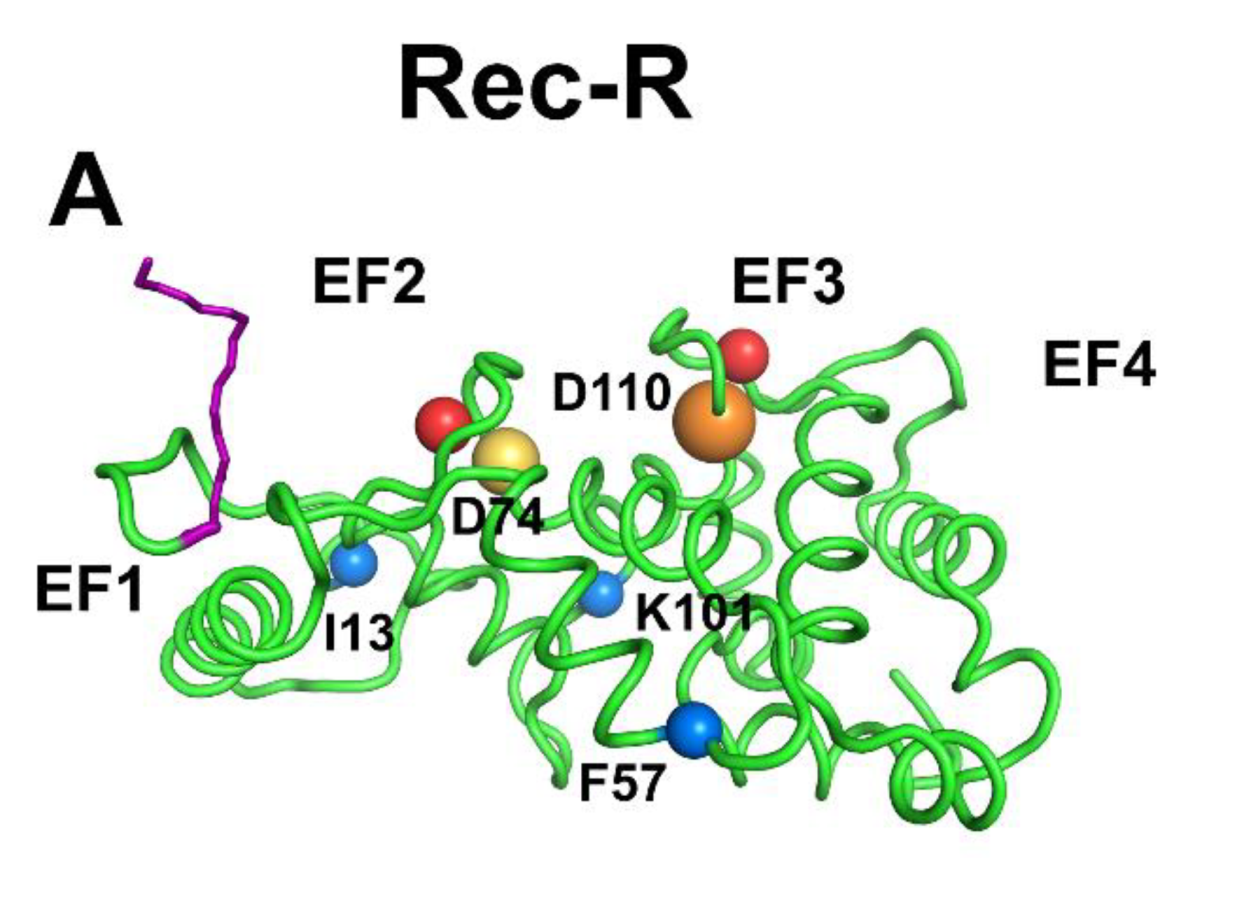

## Introduction
Recoverin is an N-myristoylated calcium-binding protein with molecular mass of 23 kDa, which is involved in visual signal transduction.
This protein modulates the Ca2+-sensitive deactivation of rhodopsinia Ca2+- dependent inhibition of rhodopsin kinase and thus participates in the regulation of the photoresponse duration.
Potential Ca2+- binding sites are distributed relatively uniformly within the recoverin sequence and include amino acids between 36 and 48 (EF1), 73 and 85 (EF2), 109 and 121 (EF3) and 159 and 170 (EF4). Of the four potential Ca2+- binding sites, only two (the second and the third) EF-hands are capable of binding Ca2+, whereas the remaining two sites (the first and the fourth) do not possess this ability. [S. E.Permyakov et al. 2000]

The most prominent feature of recoverin is the calcium-myristoyl switch. Myristoryl group is normally sequestered away in the protein's hydrophobic interior binding pocket. When the protein binds calcium ions, change in conformation brings out myristoyl group from the binding pocket so that the myristoyl group can interact with the target or the protein can translocate to a different region.

Remarkable changes in protein structure lead to the activation of protein, then Myristoyl group can now look for its target in the membranes. [http://calcium.uhnres.utoronto.ca/story/recoverin.html]
The point in which the mutation was inserted has been selected considering the analyses of the PSN (Protein Structure Network), performed with the PyInteraph package. 

The missence mutation has been effectuated on the aminoacid 110, in the EF-hand3, mutating the original aspartate into an alanine. The wild-type residue was found to be a hub of degree 8.
Substitution with alanine removes all sidechain atoms past the β-carbon, in fact, through alanine mutagenesis it is possible to obtain a detailed map of functional epitopes. [Kim L Morrison and Gregory A Weiss, 2001]
This kind of mutation has been done in order to analyze the change in the behavior of the mutated protein compare to the wild type one, at this point of the work only in a protein already bound to the membrane through the myristoyl.

***

In [1]:
# Generic libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML

from matplotlib import rc


In [1]:
# MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.coordinates.base import Timestep
from MDAnalysis.analysis import contacts
from MDAnalysis.lib import distances
from MDAnalysis.analysis.base import analysis_class
from MDAnalysis.lib.distances import capped_distance, self_capped_distance
from MDAnalysis.lib.distances import distance_array, self_distance_array
import MDAnalysis.analysis.hbonds as hb
from scipy.spatial.distance import squareform
from itertools import product
import inspect
import multiprocessing
import time
import os
import glob

ModuleNotFoundError: No module named 'tqdm.auto'

In [3]:
## Import common data (e.g. pdb and psf files)
from pathlib import Path
simdir = Path('../G02-data/01-raw/04-mutated-membrane/')
PSF = simdir / 'mut_rec_r_memb_solv_ion.psf'
PDB = simdir / 'mut_rec_r_memb_solv_ion.pdb'

In [4]:
## autocorrelation estimate for box-averaging
def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    #r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]) #slow method using the definition
    r = np.correlate(x, x, mode = 'full')[-n:] # fast method, same result!
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

***

## Equilibration

The equilibration process was performed through the following steps:
0. Energy minimization (1000 steps) using the conjugate gradients method
1. NPT solvent equilibration for 200ps, with constant area -> new box height
2. NVT solvent equilibration for 250ps
3. NVT lipid tails equilibration for 250ps
4. NVT all-system equilibration for 250ps -> temperature convergence
5. NPT all-system equilibration for 500ps, with free area -> pressure (and volume) convergence

In [5]:
# load all necessary equilibration info
path = "../G02-data/02-processed/"

E1 = pd.read_csv(path+'eq1/total-energy.dat', delimiter = ' ')
V1 = pd.read_csv(path+'eq1/volume.dat', delimiter = ' ')
P1 = pd.read_csv(path+'eq1/pressureavg.dat', delimiter = ' ')
E2 = pd.read_csv(path+'eq2/total-energy.dat', delimiter = ' ')
E3 = pd.read_csv(path+'eq3/total-energy.dat', delimiter = ' ')
T3 = pd.read_csv(path+'eq3/temperature.dat', delimiter = ' ')
E4 = pd.read_csv(path+'eq4/total-energy.dat', delimiter = ' ')
T4 = pd.read_csv(path+'eq4/temperature.dat', delimiter = ' ')
P4 = pd.read_csv(path+'eq4/pressureavg.dat', delimiter = ' ')
E5 = pd.read_csv(path+'eq5/total-energy.dat', delimiter = ' ')
T5 = pd.read_csv(path+'eq5/temperature.dat', delimiter = ' ')
P5 = pd.read_csv(path+'eq5/pressureavg.dat', delimiter = ' ')
V5 = pd.read_csv(path+'eq5/volume.dat', delimiter = ' ')
E_all = pd.concat([E1[600:-1], E2, E3, E4, E5]) # minimization energies are exluded

#convert time to nanoseconds
timestep = 2e-6 # in ns
E_all['t [ns]'] = E_all['TS']*timestep
V1['t [ns]'] = V1['TS']*timestep
P1['t [ns]'] = P1['TS']*timestep
E2['t [ns]'] = E2['TS']*timestep
E3['t [ns]'] = E3['TS']*timestep
T3['t [ns]'] = T3['TS']*timestep
T4['t [ns]'] = T4['TS']*timestep
P4['t [ns]'] = P4['TS']*timestep
T5['t [ns]'] = T5['TS']*timestep
P5['t [ns]'] = P5['TS']*timestep
V5['t [ns]'] = V5['TS']*timestep

Text(0, 0.5, 'Etot [kcal/mol]')

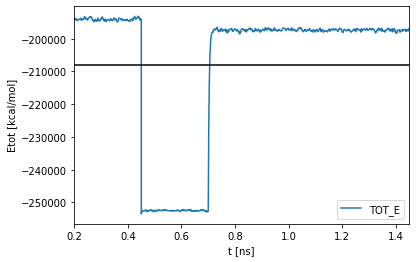

In [5]:
mean = (E_all["TOT_E"]).mean()
#print('Emean =', mean)
#E_all["TOTAL_rolling"] = E_all["TOT_E"].rolling(window=10,center=True).mean()
ax = E_all.plot(x='t [ns]', y='TOT_E')
plt.ylabel("Etot [kcal/mol]")
ax.axhline(mean, color='black', label="TOTAL mean")
#E_all.plot(x='t [ns]', y='TOTAL_rolling', ax=ax, color='red')
plt.ylabel("Etot [kcal/mol]")

Text(0, 0.5, 'z [nm]')

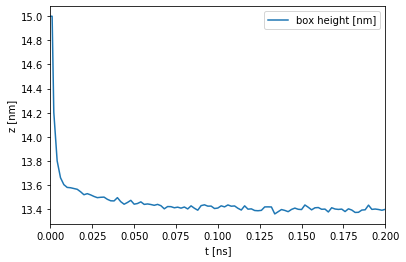

In [6]:
box_area = 93.1166**2
V1['box height [nm]'] = V1['V'] / box_area / 10

ax = V1.plot(x='t [ns]', y='box height [nm]')
plt.ylabel("z [nm]")

Tmean = 309.1223


Text(0, 0.5, 'T [K]')

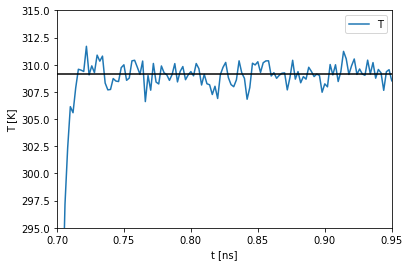

In [7]:
mean = (T4["T"][-100:-1]).mean()
print('Tmean =', mean)

#fig = plt.figure()
ax = T4.plot(x='t [ns]', y='T')
ax.axhline(mean, color='black', label="mean")
ax.set_ylim(295, 315)
plt.ylabel("T [K]")

Pmean = 0.992775298804781


Text(0, 0.5, 'Pavg [bar]')

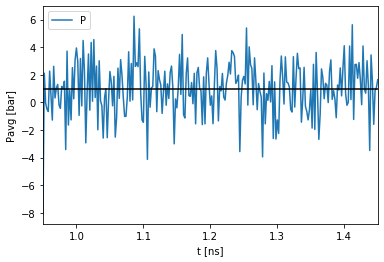

In [8]:
mean = (P5["P"]).mean()
print('Pmean =', mean)

#fig = plt.figure()
ax = P5.plot(x='t [ns]', y='P')
ax.axhline(mean, color='black', label="mean")
plt.ylabel("Pavg [bar]")

Not enough datapoints to even make an accurate mean.

zmean = 1162.703338792032  zlast = 1161.8310622000001


Text(0, 0.5, 'V [nm^3]')

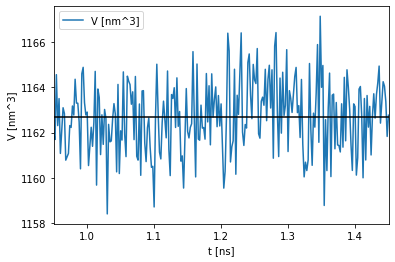

In [9]:
box_area = 93.1166**2
V5['box height [nm]'] = V5['V'] / box_area / 10
V5['V [nm^3]'] = V5['V'] / 1000
mean = (V5["V [nm^3]"]).mean()
print('zmean =', mean, ' zlast =', V5['V [nm^3]'][249])

#fig = plt.figure()
ax = V5.plot(x='t [ns]', y='V [nm^3]')
ax.axhline(mean, color='black', label="mean")
plt.ylabel("V [nm^3]")

First 10ns of the simulation are considered as a further equilibration and excluded from the subsequent data analysis.

In [10]:
# import first 10ns of production run
E6 = pd.read_csv(path+'eqfinal/total-energy.dat', delimiter = ' ')
T6 = pd.read_csv(path+'eqfinal/temperature.dat', delimiter = ' ')
V6 = pd.read_csv(path+'eqfinal/volume.dat', delimiter = ' ')
P6 = pd.read_csv(path+'eqfinal/pressure.dat', delimiter = ' ')
E6['t [ns]'] = E6['TS']*timestep
T6['t [ns]'] = T6['TS']*timestep
V6['t [ns]'] = V6['TS']*timestep
V6['V [nm^3]'] = V6['V'] / 1000
P6['t [ns]'] = P6['TS']*timestep


Vmean = 1162.8167718309383


<Figure size 432x288 with 0 Axes>

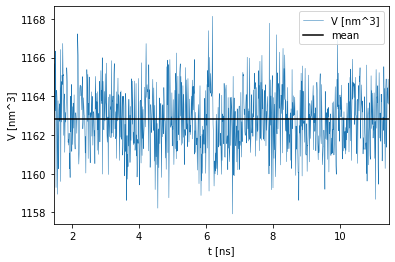

In [11]:
mean = (V6["V [nm^3]"]).mean()
print('Vmean =', mean)

fig = plt.figure()
ax = V6.plot(x='t [ns]', y='V [nm^3]', lw=0.5)
ax.set_ylabel("V [nm^3]")
ax.axhline(mean, color='black', label="mean")
ax.legend()

***

# Production run



In [6]:
## Check on thermodinamic data from the logs
path = "../G02-data/02-processed/"
output_name = "protmemb"
E = pd.read_csv(path+'total-energy.dat', delimiter = ' ')
T = pd.read_csv(path+'temperature.dat', delimiter = ' ')
V = pd.read_csv(path+'volume.dat', delimiter = ' ')
P = pd.read_csv(path+'pressureavg.dat', delimiter = ' ')

timestep = 2e-6 # in ns
E['t [ns]'] = E['TS']*timestep
T['t [ns]'] = T['TS']*timestep
V['t [ns]'] = V['TS']*timestep
V['V [nm^3]'] = V['V'] / 1000
P['t [ns]'] = P['TS']*timestep

Pmean = 1.1626891188798594


Text(0, 0.5, 'Pavg [bar]')

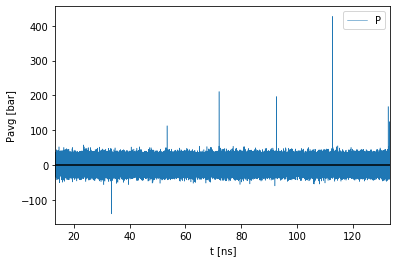

In [7]:
mean = (P["P"]).mean()
print('Pmean =', mean)
ax = P.plot(x='t [ns]', y='P', lw=0.5)
ax.axhline(mean, color='black', label="mean")
plt.ylabel("Pavg [bar]")


In [14]:

#mean = (E["E_TOT"]).mean()
#print('Emean =', mean)

ax = E.plot(x='t [ns]', y='E_TOT', lw=0.5)
#ax.axhline(mean, color='black', label="mean")
plt.ylabel("Etot [kJ/mol]")


KeyError: 'E_TOT'

In [ ]:
mean = (P["P"]).mean()
print('Pmean =', mean)
ax = P.plot(x='t [ns]', y='P', lw=0.5)
ax.axhline(mean, color='black', label="mean")
plt.ylabel("Pavg [bar]")

Text(0, 0.5, 'acf')

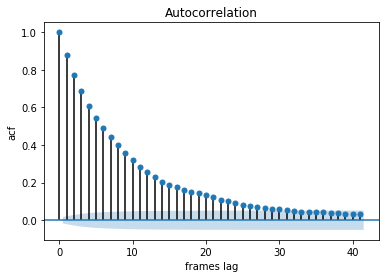

In [25]:
## estimation of the autocorrelation function from the energy log of a run with improved logging
# this 2500000 steps run had nsenergy = 200, i.e. one point per 0.4ps

E_dense = pd.read_csv(path+'logg/total-energy.dat', delimiter = ' ')
nlog = len(E_dense['TOT_E'])

# acf = estimated_autocorrelation(E_dense['TOT_E'])
# alternativa da pandas: autocorrelation_plot(E_dense)
# o ancora da statsmodels: plot_acf(E_dense)

import statsmodels.api as sm
ax = sm.graphics.tsa.plot_acf(E_dense['TOT_E'], unbiased=True, fft=False)
plt.xlabel("frames lag")
plt.ylabel("acf")

#plt.plot(acf[1:nlog//2])

Dopo circa 30 frames (0.6ns) i dati dell'energia totale sono scorrelati.

Poco utile, togliere da report.




***

## Trajectory analysis

In [11]:
## import trajectory data 
trajdir = '../G02-data/02-processed/trajectories/'
DCDsmall = trajdir + 'memb_prodrun_tot_small.dcd'
DCD = trajdir + 'memb_prodrun_tot.dcd'

## universe creation
u = mda.Universe(str(PSF), str(DCD))
u_new = u.copy() # used as a reference in memory for mapping calcuations
ref0 = mda.Universe(str(PSF), str(PDB))
print(u.select_atoms("protein or resname GLYM or name MG").n_atoms)

# other info
nframes = u.trajectory.n_frames
dt = 0.02 # ns per frame
time = np.arange(0, dt*nframes, dt)
print(time[-1])

3301
193.48000000000002


In [9]:
# import trajectory data of the WT Recoverin
trajdir_wt = '/mnt/data/XTC/'
PSF_wt = PSF
PDB_wt = trajdir_wt + 'rec_r_membrane.pdb'
DCD_wt = trajdir_wt + 'rec_r_r2_extended.xtc'

# universe creation
u_wt = mda.Universe(str(PDB_wt), str(DCD_wt))
u_new_wt = u_wt.copy() # used as a reference in memory for mapping calcuations
ref0_wt = mda.Universe(str(PDB_wt))
print(u_wt.select_atoms("protein or resname GLYM").n_atoms)

# other info
nframes_wt = u_wt.trajectory.n_frames
dt_wt = 0.01 # ns per frame
time_wt = np.arange(0, dt_wt*nframes_wt, dt_wt)

3253


In [10]:
path = "../G02-data/02-processed/"
plotpath = "../G02-report/imgs/"
output_name = "protmemb"
%matplotlib notebook

### Radius of gyration

$$R_\mathrm{gyr} = \sqrt{\frac{1}{M}\sum_{i=1}^{N} m_i(\mathbf{r}_i - \mathbf{R})^2}$$

In [10]:
stride = 1
Rgyr = []
ca = u.select_atoms("backbone")
for ts in u.trajectory[0:nframes-1:stride]:
   Rgyr.append(ca.radius_of_gyration())
Rgyr = np.array(Rgyr)

print(len(Rgyr))

rel_diff = (max(Rgyr) - min(Rgyr))/10

9674


<IPython.core.display.Javascript object>


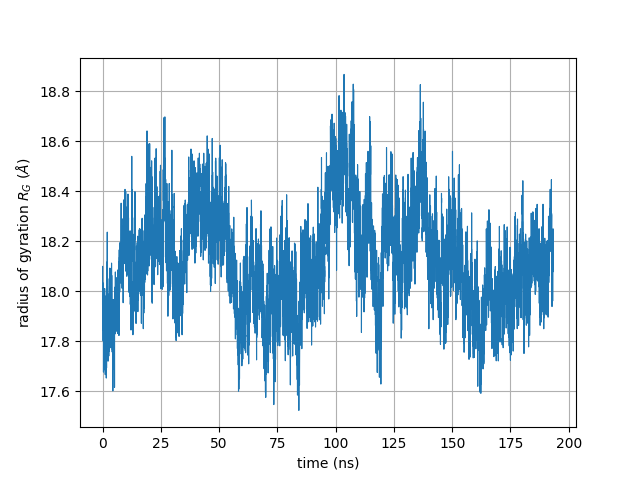

In [12]:
%matplotlib notebook
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(time[0:nframes-1:stride], Rgyr, lw=0.8, label=r"$R_G$")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
ax.figure.savefig(plotpath+output_name+"_Rgyr.pdf")
plt.grid()

In [13]:
stride_wt = 2
Rgyr_wt = []
ca_wt = u_wt.select_atoms("backbone")
for ts in u_wt.trajectory[0:nframes_wt-1:stride_wt]:
   Rgyr_wt.append(ca_wt.radius_of_gyration())
Rgyr_wt = np.array(Rgyr_wt)
print(len(Rgyr_wt))
#rel_diff = (max(Rgyr) - min(Rgyr))/10

10000


In [14]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(time[0:nframes-1:stride], Rgyr, lw=0.6, label=r"$D110A$")
ax.plot(time_wt[0:nframes_wt-1:stride_wt], Rgyr_wt, lw=0.75, label=r"$WT$")
ax.set_xlabel("time (ns)")
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_Rgyr_comp.pdf'))

<IPython.core.display.Javascript object>

In [15]:
mean_d110a = np.mean(Rgyr)
mean_wt = np.mean(Rgyr_wt)
std_d110a = np.std(Rgyr)
std_wt = np.std(Rgyr_wt)
print(mean_d110a, std_d110a)
print(mean_wt, std_wt)

18.12689959990061 0.20172155694175622
18.017561899220105 0.14761093223596342


In [18]:
## estimation of the autocorrelation function

nlog = len(Rgyr)
nlog_wt = len(Rgyr_wt)
print(nlog)
print(nlog_wt)   
    
# acf = estimated_autocorrelation(E_dense['TOT_E'])
# alternativa da pandas: autocorrelation_plot(E_dense)
# o ancora da statsmodels: plot_acf(E_dense)

#import statsmodels.api as sm
#ax = sm.graphics.tsa.plot_acf(Rgyr, unbiased=True, fft=False)
#ax2 = sm.graphics.tsa.plot_acf(Rgyr_wt, unbiased=True, fft=False)
#plt.xlabel("frames lag")
#plt.ylabel("acf")

acf = estimated_autocorrelation(Rgyr)
acf_wt = estimated_autocorrelation(Rgyr_wt)


9674
10000


<IPython.core.display.Javascript object>


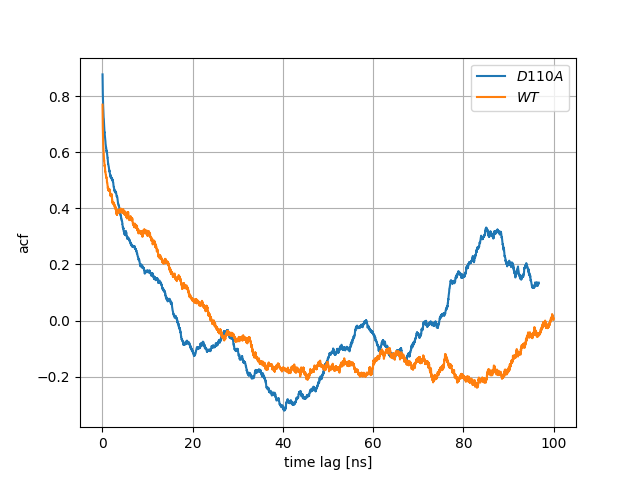

In [20]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(1,nlog//2)*dt, acf[1:nlog//2], label=r"$D110A$")
ax.plot(np.arange(1,nlog_wt//2)*dt, acf_wt[1:nlog_wt//2], label=r"$WT$")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'_Rgyr_corr.pdf'))

The radius of gyration varies of tot nm, but we cannot conclude anything from its behaviour.

### RMSD

$$RMSD_i = \left[\frac{1}{N}\sum_{n_j=1}^N |\mathbf{r}_n(t_i)-\mathbf{r}_n(t_{ref})|^2\right]^{1/2}$$


In [21]:
# for mutated
from MDAnalysis.analysis.rms import rmsd

stride = 5
reduced_index = list(range(0, nframes, stride))

# extract using ancient lovecraftian invocations the positions in the last frame of the DCD
#ref_end = [u.select_atoms('protein and name CA').positions for ts in u.trajectory[nframes-1:nframes]][0]
#print(np.shape(ref_end))
ref_start = [u.select_atoms('protein and name CA').positions for ts in u.trajectory[0:1]][0]

# ~5 minutes for a stride=10
rmsd_b = [rmsd(u.select_atoms('protein and name CA').positions, ref_start, \
                  center=True, superposition=True) for ts in u.trajectory[reduced_index]]


In [22]:
# for WT
stride_wt = 10
reduced_index = list(range(0, nframes_wt, stride_wt))

ref_start_wt = [u_wt.select_atoms('protein and name CA').positions for ts in u_wt.trajectory[0:1]][0]

rmsd_b_wt = [rmsd(u_wt.select_atoms('protein and name CA').positions, ref_start_wt, \
                  center=True, superposition=True) for ts in u_wt.trajectory[reduced_index]]


In [23]:
# plot of the backbone RMSD
fig = plt.figure()

plt.plot(time[stride:-1:stride], rmsd_b[0:-1], lw=0.75, label='D110A')
plt.plot(time_wt[stride:-1:stride_wt], rmsd_b_wt[0:-1], lw=0.75, label='WT')

plt.xlabel('Time [ns]')
plt.ylabel('RMSD')
plt.title(r'RMSD of the C$\alpha$')
plt.ylim(bottom=0)
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rmsd_comparison.pdf'))

<IPython.core.display.Javascript object>

The RMSD increases to rather high values since the beginning of the simulation, corresponding to a stretching of the protein structure which seems to want to get far from the membrane. 

In the last ~20 ns of simulation it returns closer to the membrane, in a state that by this simple, low-dimensional, indicator appears to be closer to the initial conformation, but that has to be further analysed.

In [24]:
# !!!  takes really _a lot_ of time   !!! (~8 hours with stride of 30 for 140ns)
# TODO: use all cores, or write it in Julia
reduced_index = list(range(0, nframes, 30))

rmsd_map = [ rmsd(u.select_atoms('protein and name CA').positions, \
                u_new.select_atoms('protein and name CA').positions, center=True, superposition=True) \
                for ts in u.trajectory[reduced_index] for ts_one in u_new.trajectory[reduced_index] ]
rmsd_map = np.array(rmsd_map).reshape((len(reduced_index),len(reduced_index)))


KeyboardInterrupt: 

In [ ]:
print(bckb)


In [ ]:
plt.figure(figsize=((10,10)))
plt.title("RMSD heatmap", fontsize=20)
img = plt.imshow(rmsd_map)
plt.colorbar(img);

### RMSF
- measures the fluctuations of each atom with respect to the equlibrium
- proportional to the temperature ($\beta$) factor
- useful to match experimental results


$$RMSF_i = \left[\frac{1}{T}\sum_{t_j=1}^T |\mathbf{r}_i(t_j)-\mathbf{r}_i|^2\right]^{1/2}$$



In [25]:
# fairly slow
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import align
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.analysis.base import AnalysisFromFunction

protein = u.select_atoms("protein")
u_protein = mda.Merge(protein).load_new(
         AnalysisFromFunction(lambda ag: ag.positions.copy(),
                              protein).run().results, format=MemoryReader)

ca_atoms = u.select_atoms("protein and name CA")
ca_myr = u.select_atoms("protein and name CA and (resname GLYM and not name NOH)")

# Fit to the initial frame to get a better average structure
# ref = average structure
prealigner = align.AlignTraj(u_protein, u_protein, select="protein and name CA", in_memory=True).run()

# Make a reference structure (need to reshape into a 1-frame "trajectory").
ref_coordinates = u_protein.trajectory.timeseries(asel=None).mean(axis=1) # none means everything in the universe
print(ref_coordinates)
print(len(ref_coordinates))

# new universe reference that contains a single frame with the averaged coordinates of the protein. 
ref = mda.Merge(protein).load_new(ref_coordinates[:, None, :], order="afc")

# Now we need to fit the whole trajectory to the reference by minimizing the RMSD.
aligner = align.AlignTraj(u_protein, ref, select="protein and name CA", in_memory=True).run()

print(ref)

[[-18.86605     4.066095   16.765648 ]
 [-19.261396    3.9595704  16.784807 ]
 [-18.294895    3.965773   17.409117 ]
 ...
 [  2.246353  -16.166538   60.697395 ]
 [  2.265494  -16.560549   61.12378  ]
 [  1.5507197 -16.781904   61.086765 ]]
3251
<Universe with 3251 atoms>


In [26]:

# write the trajectory to disk (!! GBs of data !!)
with mda.Writer(trajdir + "rmsfit.dcd", n_atoms=u_protein.atoms.n_atoms) as W:
    for ts in u_protein.trajectory:
        W.write(u_protein.atoms)
        

In [27]:
#ufit = mda.Universe(PSF, trajdir + "rmsfit.dcd")
protein_fit = u_protein.select_atoms("protein")
calphas_fit = u_protein.select_atoms("protein and name CA")
calphas = u.select_atoms("protein and name CA")

rmsfer = RMSF(calphas_fit, verbose=True).run()
#rmsfer = RMSF(ca_atoms).run()
calphas_fit

Step  9675/9675 [100.0%]


<AtomGroup with 200 atoms>

<IPython.core.display.Javascript object>


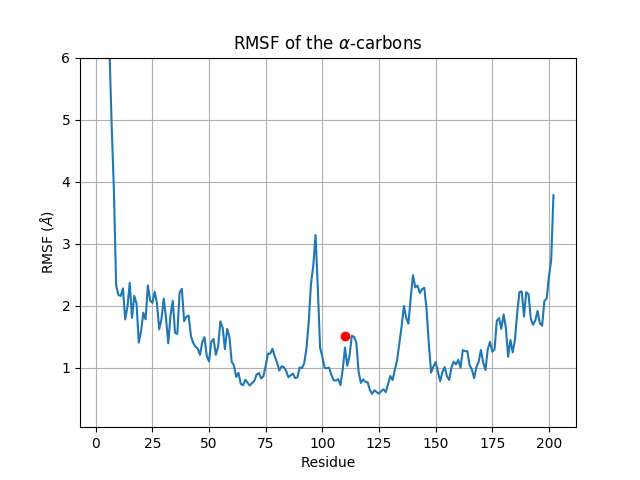

In [28]:
fig = plt.figure()
plt.plot(calphas_fit.resnums, rmsfer.rmsf)
#plt.axvline(x=110, color='r', lw=0.8)
plt.plot(110, rmsfer.rmsf[110], 'o', label='mutated alanine', color='red')
plt.ylim(top=6)
plt.xlabel('Residue')
plt.ylabel('RMSF ($\AA$)')
plt.title(r'RMSF of the $\alpha$-carbons')
plt.grid()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rmsf.pdf'))

In [29]:
rmsfer1 = RMSF(calphas_fit, verbose=True, n_jobs=2, start=1, stop=nframes//4).run()
rmsfer2 = RMSF(calphas_fit, verbose=True, n_jobs=2, start=nframes//4, stop=nframes//2).run()
rmsfer3 = RMSF(calphas_fit, verbose=True, n_jobs=2, start=nframes//2, stop=3*nframes//4).run()
rmsfer4 = RMSF(calphas_fit, verbose=True, n_jobs=2, start=3*nframes//4, stop=nframes-1).run()


/home/kryohi/.miniconda3/lib/python3.7/site-packages/MDAnalysis/analysis/base.py:116: DeprecationWarning: Setting the following kwargs should be done in the run() method: start, stop
  DeprecationWarning)
Step  2417/2417 [100.0%]
Step  2419/2419 [100.0%]
Step  2419/2419 [100.0%]
Step  2418/2418 [100.0%]


<IPython.core.display.Javascript object>


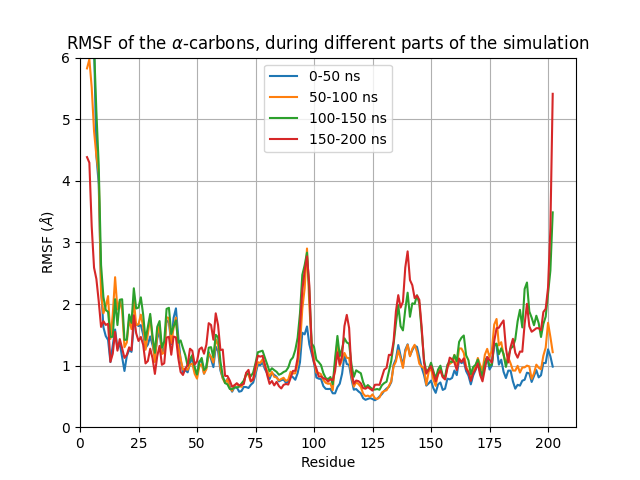

In [30]:
fig = plt.figure()
plt.plot(calphas_fit.resnums, rmsfer1.rmsf, label='0-50 ns')
plt.plot(calphas_fit.resnums, rmsfer2.rmsf, label='50-100 ns')
plt.plot(calphas_fit.resnums, rmsfer3.rmsf, label='100-150 ns')
plt.plot(calphas_fit.resnums, rmsfer4.rmsf, label='150-200 ns')
#plt.axvline(x=59, color='r', lw=0.8)
plt.ylim(top=6, bottom=0)
plt.xlim(left=0)
plt.xlabel('Residue')
plt.ylabel('RMSF ($\AA$)')
plt.title(r'RMSF of the $\alpha$-carbons, during different parts of the simulation')
plt.grid()
plt.legend(loc=0)
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rmsf_part.pdf'))

In [31]:
#stessa cosa con traiettoria wt

protein_wt = u_new_wt.select_atoms("protein")
print(protein_wt)

u_protein_wt = mda.Merge(protein_wt).load_new(
         AnalysisFromFunction(lambda ag: ag.positions.copy(), protein_wt).run().results,
    format=MemoryReader, in_memory=True)

print(u_protein_wt)

<AtomGroup [<Atom 50: N of type N of resname ASN, resid 3 and segid X and altLoc >, <Atom 51: HN of type H of resname ASN, resid 3 and segid X and altLoc >, <Atom 52: CA of type C of resname ASN, resid 3 and segid X and altLoc >, ..., <Atom 3300: OT1 of type O of resname LEU, resid 202 and segid X and altLoc >, <Atom 3301: OT2 of type O of resname LEU, resid 202 and segid X and altLoc >, <Atom 3302: HT2 of type H of resname LEU, resid 202 and segid X and altLoc >]>
<Universe with 3253 atoms>


In [32]:

# Fit to the initial frame to get a better average structure
# ref = average structure
prealigner = align.AlignTraj(u_protein_wt, u_protein_wt, select="protein and name CA", in_memory=True).run()

# Make a reference structure (need to reshape into a 1-frame "trajectory").
ref_coordinates_wt = u_protein_wt.trajectory.timeseries(asel=None).mean(axis=1)#none means everything in the universe
#ref_coordinates_wt = AnalysisFromFunction(lambda ag: ag.positions.copy(), protein_wt).run().results
#ref_coordinates_wt = ref_coordinates_wt.mean(axis=1)
print(ref_coordinates_wt)
print(len(ref_coordinates_wt))

# new universe reference that contains a single frame with the averaged coordinates of the protein. 
ref_wt = mda.Merge(protein_wt).load_new(ref_coordinates_wt[:, None, :], order="afc", format=MemoryReader)
#ref_wt = mda.Merge(protein_wt)            # create the protein-only Universe
#ref_wt.load_new(ref_coordinates_wt[:, None, :], order="afc", format=MemoryReader)

# Now we need to fit the whole trajectory to the reference by minimizing the RMSD.
aligner = align.AlignTraj(u_protein_wt, ref_wt, select="protein and name CA", in_memory=True).run()

print(ref_wt)

[[ 34.830975  98.14579   66.84701 ]
 [ 35.41668   98.05346   66.642   ]
 [ 34.380116  98.41981   67.83119 ]
 ...
 [ 57.221058  73.30831   99.5681  ]
 [ 57.25508   73.18533   99.73866 ]
 [ 56.621574  73.46414  100.25861 ]]
3253
<Universe with 3253 atoms>


In [33]:
# write the trajectory to disk
with mda.Writer(trajdir_wt + "rmsfit_wt.xtc", n_atoms=u_protein_wt.atoms.n_atoms) as W:
    for ts in u_protein_wt.trajectory:
        W.write(u_protein_wt.atoms)
        

In [34]:
#ufit_wt = mda.Universe(PDB_wt, trajdir_wt + "rmsfit_wt.xtc")
#protein_fit_wt = u_protein_wt.select_atoms("protein")
calphas_fit_wt = u_protein_wt.select_atoms("protein and name CA")
#calphas_wt = u_wt.select_atoms("protein and name CA")

rmsfer_wt = RMSF(calphas_fit_wt, verbose=True).run()
print(calphas_fit_wt)
print(len(rmsfer_wt.rmsf))

Step 20001/20001 [100.0%]


<AtomGroup [<Atom 3: CA of type C of resname ASN, resid 3 and segid X and altLoc >, <Atom 17: CA of type C of resname SER, resid 4 and segid X and altLoc >, <Atom 28: CA of type C of resname LYS, resid 5 and segid X and altLoc >, ..., <Atom 3191: CA of type C of resname LYS, resid 200 and segid X and altLoc >, <Atom 3213: CA of type C of resname LYS, resid 201 and segid X and altLoc >, <Atom 3235: CA of type C of resname LEU, resid 202 and segid X and altLoc >]>
200


<IPython.core.display.Javascript object>


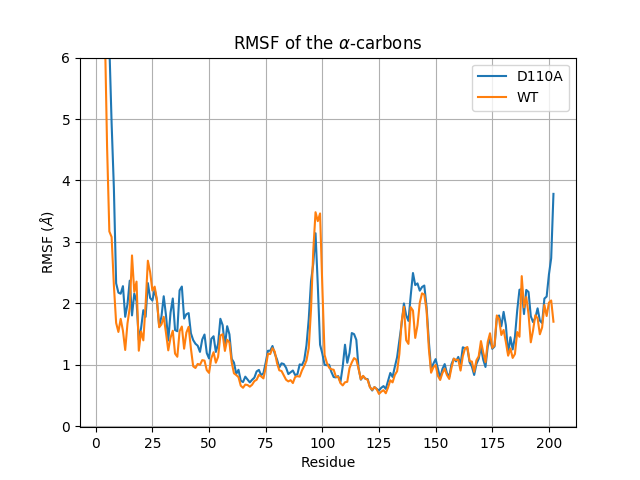

In [35]:
fig = plt.figure()
plt.plot(calphas_fit.resnums, rmsfer.rmsf, label='D110A')
plt.plot(calphas_fit_wt.resnums, rmsfer_wt.rmsf, label='WT')
plt.ylim(top=6)
#plt.plot(110,rmsfer.rmsf[110],'o', label='mutated alanine', color='red')
plt.xlabel('Residue')
plt.ylabel('RMSF ($\AA$)')
plt.title(r'RMSF of the $\alpha$-carbons')
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rmsf_comparison.pdf'))

In [36]:
rmsfer1_wt = RMSF(calphas_fit_wt, verbose=True, n_jobs=2, start=1, stop=nframes_wt//4).run()
rmsfer2_wt = RMSF(calphas_fit_wt, verbose=True, n_jobs=2, start=nframes_wt//4, stop=nframes_wt//2).run()
rmsfer3_wt = RMSF(calphas_fit_wt, verbose=True, n_jobs=2, start=nframes_wt//2, stop=3*nframes_wt//4).run()
rmsfer4_wt = RMSF(calphas_fit_wt, verbose=True, n_jobs=2, start=3*nframes_wt//4, stop=nframes_wt-1).run()

/home/kryohi/.miniconda3/lib/python3.7/site-packages/MDAnalysis/analysis/base.py:116: DeprecationWarning: Setting the following kwargs should be done in the run() method: start, stop
  DeprecationWarning)
Step  4999/4999 [100.0%]
Step  5000/5000 [100.0%]
Step  5000/5000 [100.0%]
Step  5000/5000 [100.0%]


<IPython.core.display.Javascript object>


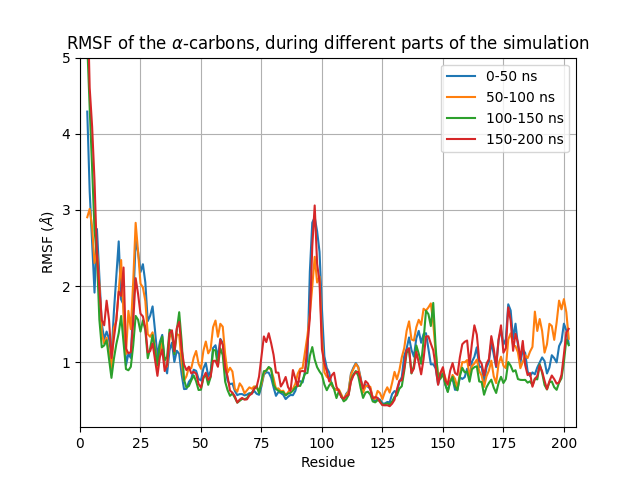

In [37]:
fig = plt.figure()
plt.plot(calphas_fit_wt.resnums, rmsfer1_wt.rmsf, label='0-50 ns')
plt.plot(calphas_fit_wt.resnums, rmsfer2_wt.rmsf, label='50-100 ns')
plt.plot(calphas_fit_wt.resnums, rmsfer3_wt.rmsf, label='100-150 ns')
plt.plot(calphas_fit_wt.resnums, rmsfer4_wt.rmsf, label='150-200 ns')
#plt.axvline(x=59, color='r', lw=0.8)
plt.ylim(top=5)
plt.xlim(left=0, right=205)
plt.xlabel('Residue')
plt.ylabel('RMSF ($\AA$)')
plt.title(r'RMSF of the $\alpha$-carbons, during different parts of the simulation')
plt.grid()
plt.legend()
plt.show()

In [38]:
rmsfer23 = RMSF(calphas_fit, verbose=True, n_jobs=2, start=nframes//2, stop=nframes-1).run()
rmsfer23_wt = RMSF(calphas_fit_wt, verbose=True, n_jobs=2, start=nframes_wt//2, stop=nframes_wt-1).run()

Step  4837/4837 [100.0%]
Step 10000/10000 [100.0%]


<IPython.core.display.Javascript object>


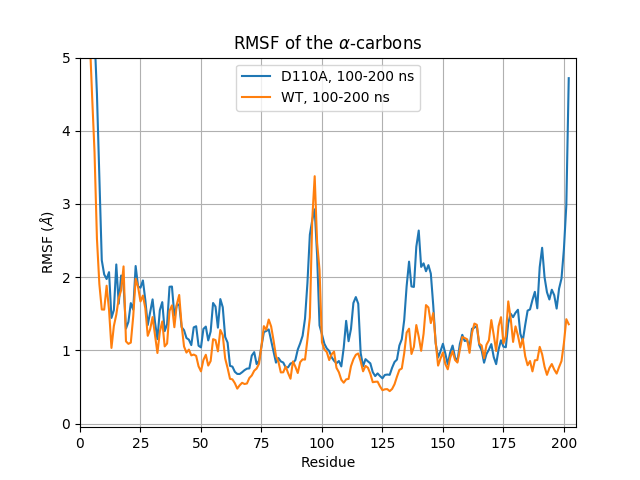

In [39]:
fig = plt.figure()
plt.plot(calphas_fit.resnums, rmsfer23.rmsf, label='D110A, 100-200 ns')
plt.plot(calphas_fit_wt.resnums, rmsfer23_wt.rmsf, label='WT, 100-200 ns')
#plt.axvline(x=59, color='r', lw=0.8)
plt.ylim(top=5)
plt.xlim(left=0, right=205)
plt.xlabel('Residue')
plt.ylabel('RMSF ($\AA$)')
plt.title(r'RMSF of the $\alpha$-carbons')
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_rmsf_comparison_half.pdf'))

### Contact Map

In [40]:
from MDAnalysis.lib import distances
Ca = [u.select_atoms('protein and name CA').positions for ts in u.trajectory[nframes-2:nframes-1]][0]
d_CaCa = distances.distance_array(Ca, Ca)
#print(d_CaCa)

In [41]:
# WT
Ca_wt = [u_wt.select_atoms('protein and name CA').positions for ts in u.trajectory[nframes-2:nframes-1]][0]
d_CaCa_wt = distances.distance_array(Ca_wt, Ca_wt)

<IPython.core.display.Javascript object>


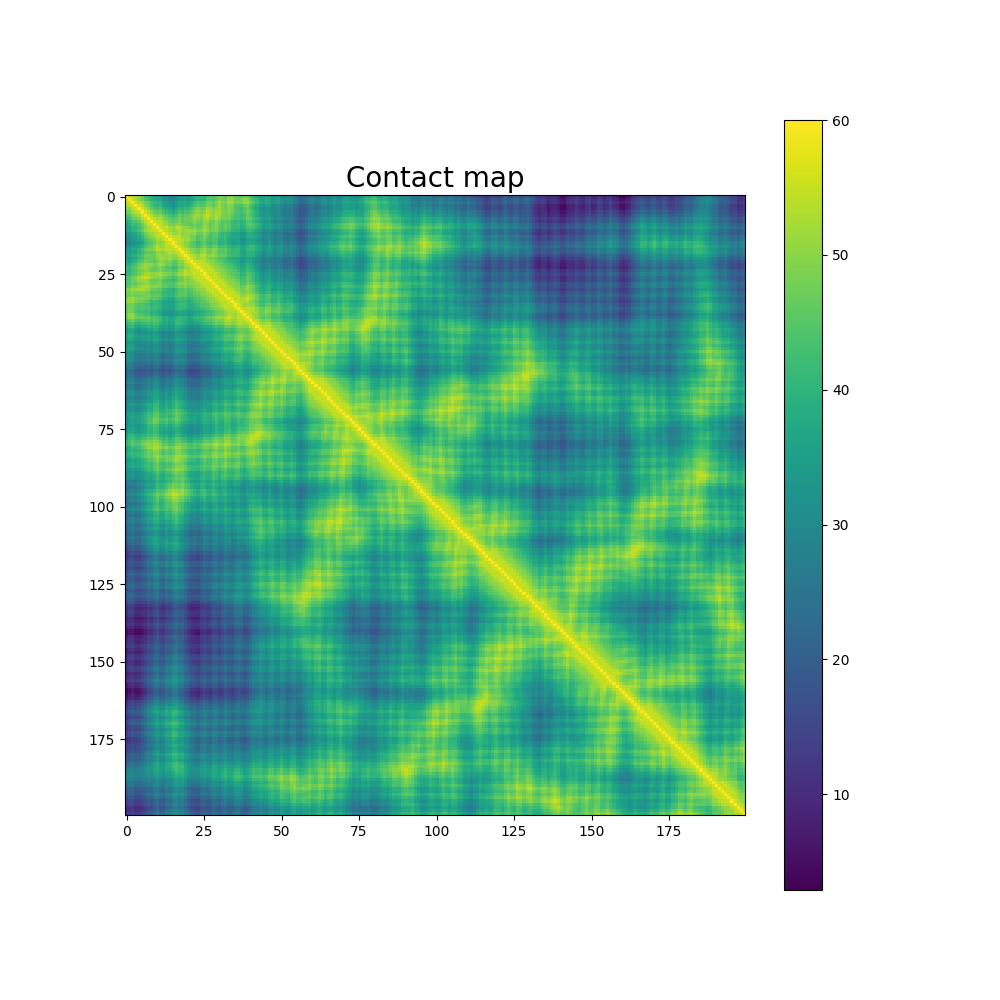

In [86]:
#fig, ax = plt.subplots()
plt.figure(figsize=((10,10)))
plt.title("Contact map", fontsize=20)
img = plt.imshow(60-d_CaCa)
plt.colorbar(img);

### Distances between protein features and the membrane, plus Myristoyl analysis

In [13]:
import MDAnalysis.lib.distances as distance

In [14]:
# center of mass of the membrane
memb = u.select_atoms('resname DGPS DGPC DGPE')
memb_cdm = [memb.center_of_mass() for ts in u.trajectory[:]]
memb_cdm = np.array(memb_cdm)
memb_z = memb_cdm[:,2]

In [15]:
# center of mass of the membrane
memb_wt = u_wt.select_atoms('resname DGPS DGPC DGPE')
memb_cdm_wt = [memb_wt.center_of_mass() for ts in u_wt.trajectory[:]]
memb_cdm_wt = np.array(memb_cdm_wt)
memb_z_wt = memb_cdm_wt[:,2]

In [16]:
# z of the center of mass of the protein, minus the z of the cdm of the membrane
prot = u.select_atoms('protein and name CA')
prot_cdm = [prot.center_of_mass() for ts in u.trajectory[:]]
prot_cdm = np.array(prot_cdm)
prot_z = prot_cdm[:,2]

pm_distance = (prot_z - memb_z) / 10

#pm_distance = pm_distance.rolling(window=10,center=True).mean()
#pm_distance = pm_distance[:,0]

In [17]:
# z of the center of mass of the protein, minus the z of the cdm of the membrane
prot_wt = u_wt.select_atoms('protein and name CA')
prot_cdm_wt = [prot_wt.center_of_mass() for ts in u_wt.trajectory[:]]
prot_cdm_wt = np.array(prot_cdm_wt)
prot_z_wt = prot_cdm_wt[:,2]

pm_distance_wt = (prot_z_wt - memb_z_wt) / 10


In [47]:
fig = plt.figure()
plt.plot(time, pm_distance, lw=0.75, label='D110A')
plt.plot(time_wt, pm_distance_wt, lw=0.75, label='WT')
plt.xlabel('time [ns]')
plt.ylabel('dz [nm]')
plt.title('protein-membrane distance')
plt.grid()
plt.show()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'_p_m_distance.pdf'))

<IPython.core.display.Javascript object>

La proteina si sta mediamente allontanando dalla membrana, intorno a 120 ns ricomincia ad avvicinarsi ma potrebbe aver subito un cambiamento conformazionale 

In [48]:
mean_d110a = np.mean(pm_distance)
mean_wt = np.mean(pm_distance_wt)
std_d110a = np.std(pm_distance)
std_wt = np.std(pm_distance_wt)
print(mean_d110a, std_d110a)
print(mean_wt, std_wt)

5.225307599867628 0.5117431235170363
4.150662898682829 0.22536965252730018


In [49]:
## estimation of the autocorrelation function

nlog = len(pm_distance)
nlog_wt = len(pm_distance_wt)
print(nlog)
print(nlog_wt)

acf = estimated_autocorrelation(pm_distance)
acf_wt = estimated_autocorrelation(pm_distance_wt)


9675
20001


In [50]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(1,nlog//2)*dt, acf[1:nlog//2], label=r"$D110A$")
ax.plot(np.arange(1,nlog_wt//2)*dt_wt, acf_wt[1:nlog_wt//2], label=r"$WT$")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'_pm_distance_corr.pdf'))

<IPython.core.display.Javascript object>

Myristoil-Protein distance:

In [51]:
# z of the center of mass of the myristoil, minus the z of the cdm of the membrane
# TODO: use a better reference (e.g. lipid heads near the myristoyl)
myr = u.select_atoms('resname GLYM and not name NOH')
myr_cdm = [myr.center_of_mass() for ts in u.trajectory[:]]
myr_cdm = np.array(myr_cdm)
myr_z = myr_cdm[:,2]

mm_distance = (myr_z - memb_z) / 10
mm_distance_smooth = np.convolve(mm_distance, np.ones((20,))/20, mode='valid')

In [52]:
fig = plt.figure()
plt.plot(time[0:len(mm_distance_smooth)], mm_distance_smooth, label='D110A')
#plt.plot(time[0:len(mm_distance_smooth)], mm_distance_smooth, lab='WT')
plt.xlabel('time [ns]')
plt.ylabel('dz [nm]')
plt.title('myristoyl-membrane distance')
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_m_m_distance.pdf'))

<IPython.core.display.Javascript object>

At 80ns it appears the Myristoyl has been extracted a bit from the lipid layer, but this measure is still too rough to capture what is happening exactly

Distance between the N-terminus of the protein and its center of mass:

In [ ]:
#ds= [[-6.7, 11.5, 17.47], [-8.22370167, 13.0, 16.83]] - [[6.77, 1., 14.47], [-8.2, 13.0, 16.83]]

In [18]:
from scipy.spatial import distance

asn3 = u.select_atoms('protein and resid 3')
asn3_cdm = [asn3.center_of_mass() for ts in u.trajectory[:]]
asn3_cdm = np.array(asn3_cdm)

#prot = u.select_atoms('protein and name CA')
#prot_cdm = [prot.center_of_mass() for ts in u.trajectory[:]]
#prot_cdm = np.array(prot_cdm)

stretch = distance.cdist(prot_cdm, asn3_cdm, 'euclidean') / 10
len(stretch)

9675

In [19]:
asn3_wt = u_wt.select_atoms('protein and resid 3')
asn3_cdm_wt = [asn3_wt.center_of_mass() for ts in u_wt.trajectory[:]]
asn3_cdm_wt = np.array(asn3_cdm_wt)

#prot_wt = u_wt.select_atoms('protein and name CA')
#prot_cdm_wt = [prot_wt.center_of_mass() for ts in u_wt.trajectory[:]]
#prot_cdm_wt = np.array(prot_cdm_wt)

stretch_wt = distance.cdist(prot_cdm_wt, asn3_cdm_wt, 'euclidean') / 10
len(stretch_wt)

20001

In [ ]:
fig = plt.figure()
plt.plot(time, stretch, lw=0.75, label='D110A')
plt.plot(time_wt, stretch_wt, lw=0.75, label='WT')
plt.xlabel('time [ns]')
plt.ylabel('dz [nm]')
#plt.title('protein-membrane distance')
plt.grid()
plt.show()
plt.legend()
plt.savefig(os.path.join(plotpath, output_name+'_p_asn3_distance.pdf'))

<IPython.core.display.Javascript object>

In [20]:
mean_d110a = np.mean(stretch)
mean_wt = np.mean(stretch_wt)
std_d110a = np.std(stretch)
std_wt = np.std(stretch_wt)
print(mean_d110a, std_d110a)
print(mean_wt, std_wt)

3.687373404164906 0.7247929276145724
2.899306752183921 0.7531881837814194


***

### SASA (TODO)

***

### Principal Component Analysis

In [21]:
import MDAnalysis.analysis.pca as pca
PSF_pca = pca.PCA(u, select='backbone', align=True)
PSF_pca.run();

In [22]:
# select components that explain >95 percent of the variance
n_pcs = np.where(PSF_pca.cumulated_variance > 0.95)[0][0]
print(n_pcs)
atomgroup = u.select_atoms('backbone')
pca_space = PSF_pca.transform(atomgroup, n_components=3)
np.shape(pca_space)

0


(9675, 3)

In [23]:
## save useful data
datapath = Path('../G02-data/03-analyzed/pca/')
pc_pc = PSF_pca.p_components
np.save(os.path.join(datapath, 'pcomponents.npy'), pc_pc)
pc_vars = PSF_pca.variance
np.save(os.path.join(datapath, 'vars.npy'), pc_vars)
pc_cvars = PSF_pca.cumulated_variance
np.save(os.path.join(datapath,'cumulativevars.npy'), pc_cvars)
pc_ma = PSF_pca.mean_atoms
pc_ma.write(os.path.join(datapath, 'meanatoms.pdb'))
np.save(os.path.join(datapath, str(n_pcs)+'components.npy'), pca_space);
%matplotlib notebook

/home/kryohi/.miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/kryohi/.miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/kryohi/.miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/kryohi/.miniconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


<IPython.core.display.Javascript object>


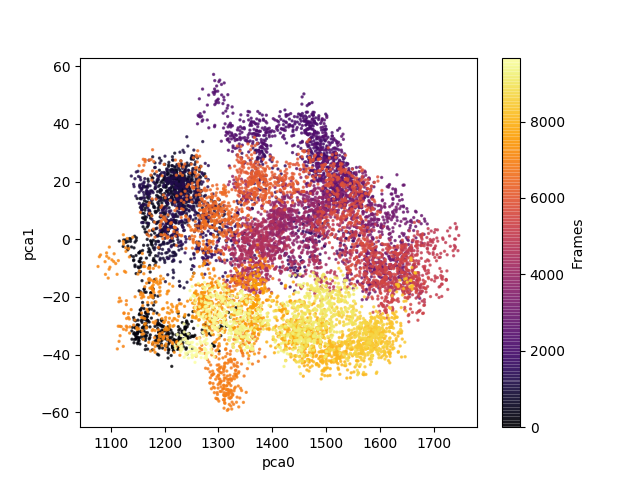

In [24]:
## plot of the 2 main components

fig = plt.figure()
pca2d = plt.scatter(pca_space[:,0], pca_space[:,1], s=2, alpha=0.7, c=np.arange(nframes), cmap='inferno')

cbar=fig.colorbar(pca2d)
cbar.set_label("Frames")
plt.xlabel('pca0')
plt.ylabel('pca1')
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_PCA01.pdf'))

<IPython.core.display.Javascript object>


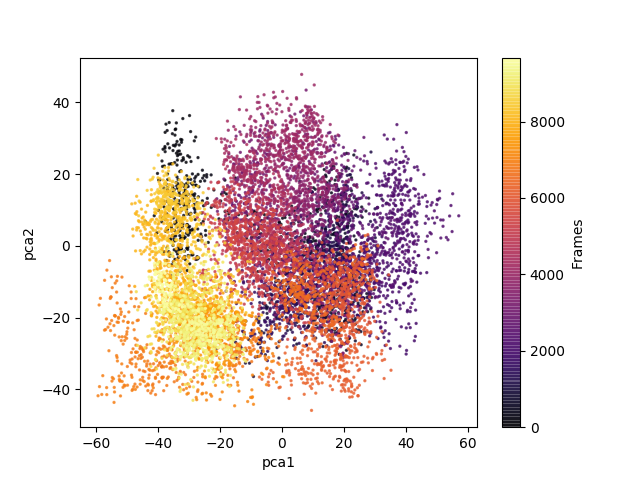

In [25]:
fig = plt.figure()
pca2d = plt.scatter(pca_space[:,1], pca_space[:,2], s=2, alpha=0.7, c=np.arange(nframes), cmap='inferno')

cbar=fig.colorbar(pca2d)
cbar.set_label("Frames")
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_PCA12.pdf'))

<IPython.core.display.Javascript object>


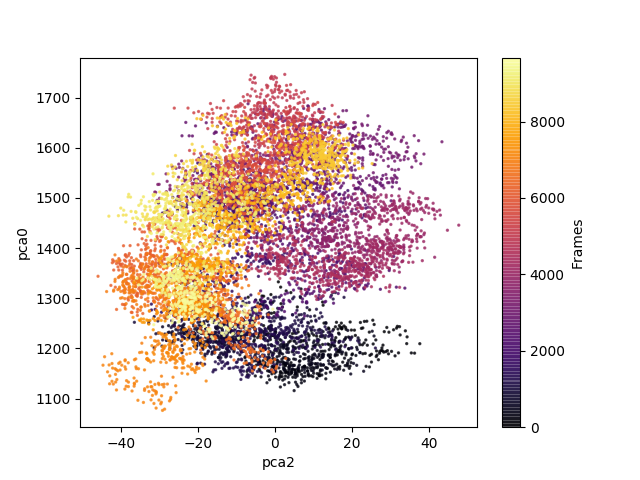

In [26]:
fig = plt.figure()
pca2d = plt.scatter(pca_space[:,2], pca_space[:,0], s=2, alpha=0.7, c=np.arange(nframes), cmap='inferno')

cbar=fig.colorbar(pca2d)
cbar.set_label("Frames")
plt.xlabel('pca2')
plt.ylabel('pca0')
plt.savefig(os.path.join(plotpath, output_name+'_PCA20.pdf'))

<IPython.core.display.Javascript object>


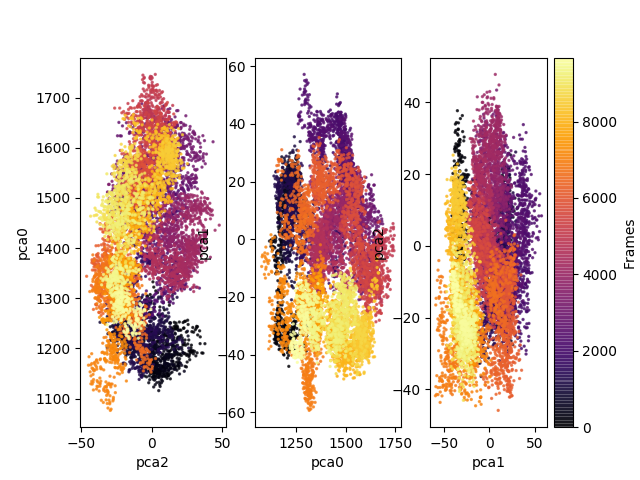

In [27]:
# put the previous plots in megazord-plot

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

pca2d = ax1.scatter(pca_space[:,2], pca_space[:,0], s=2, alpha=0.7, c=np.arange(nframes), cmap='inferno')
ax2.scatter(pca_space[:,0], pca_space[:,1], s=2, alpha=0.7, c=np.arange(nframes), cmap='inferno')
ax3.scatter(pca_space[:,1], pca_space[:,2], s=2, alpha=0.7, c=np.arange(nframes), cmap='inferno')

cbar=fig.colorbar(pca2d)
cbar.set_label("Frames")
ax1.set(xlabel='pca2', ylabel='pca0')
ax2.set(xlabel='pca0', ylabel='pca1')
ax3.set(xlabel='pca1', ylabel='pca2')

plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_PCA_all.pdf'))

<IPython.core.display.Javascript object>


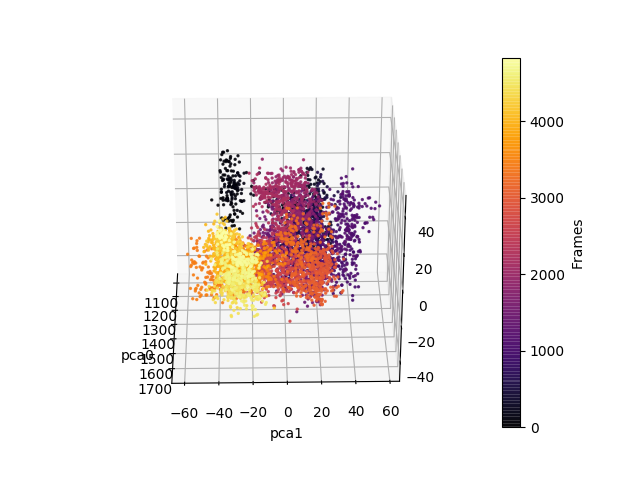

In [28]:
## plot of the 3 main components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pca3d = ax.scatter(pca_space[1:-1:2,0], pca_space[1:-1:2,1], pca_space[1:-1:2,2], s=2, alpha=0.8, c=np.arange(nframes//2), cmap='inferno')
cbar=fig.colorbar(pca3d)
cbar.set_label("Frames")

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.xlabel('pca0')
plt.ylabel('pca1')
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'_PCA3D.pdf'))

<IPython.core.display.Javascript object>


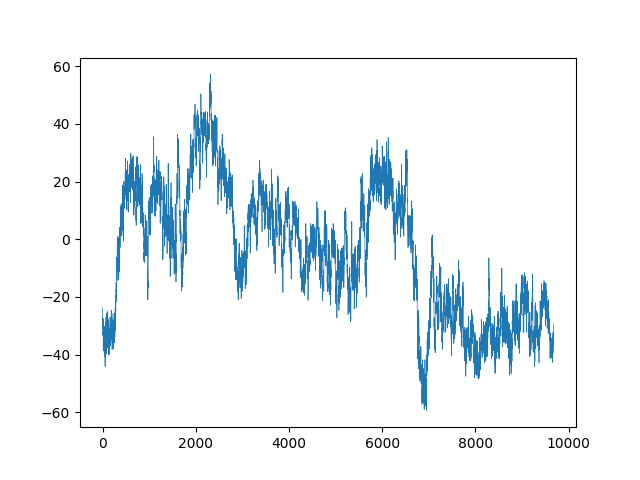

In [29]:
fig = plt.figure()
plt.plot(np.arange(nframes), pca_space[:,1], lw=0.5)

In [30]:
minpos = np.where(pca_space[:,2] == np.amin(pca_space[:,2]))[0]
minpos*dt

array([126.])

TODO
controllare _che succede_ a 139ns (min pca1) e 126ns (min pca2)

In [ ]:
## PCA quantitative results

pca_cv0 = PSF_pca.cumulated_variance
print("Contribution to the variance of the first component: ", pca_cv0[0])

pca_c0 = mda.analysis.pca.cosine_content(pca_space, 0)
pca_c1 = mda.analysis.pca.cosine_content(pca_space, 1)
pca_c2 = mda.analysis.pca.cosine_content(pca_space, 2)
print("Cosine content of the first three components: ", pca_c0, pca_c1, pca_c2)

The cosine contents don't give any meaningful information, and the result appears to be spoiled by an excessively large values of the first principal component, which we hypotesize to be related to the rotation and stretching of the whole protein, despite the alignment performed by MDAnalysis.

Thus we want to visualize the projection of the protein trajectory over the first linear component, by creating a new DCD:

In [47]:
# write the initial backbone configuration:
backbone0 = [u.select_atoms('backbone') for ts in u.trajectory[0:1]][0]
backbone0.write(os.path.join(datapath,"backbone0.pdb"))

# define useful variables
start, stop, step = u.trajectory.check_slice_indices(None, None, 1)
n_frames = len(range(start, stop, step))
n_components = pc_pc.shape[1]
n_atoms = int(pc_pc.shape[0]/3)
components = pc_pc[:, :n_pcs] # why not pca_spce?

# iterate over the 3 main components and save their respective trajectories
for component in range(components.shape[1]):
    yc = np.zeros((n_frames, components.shape[0]))
    for time, weights in enumerate(pca_space):
        for atom in range(components.shape[0]):
            yc[time, atom] = weights[component] * components[atom, component]
    yc = yc.reshape(n_frames, n_atoms, 3)

    with mda.Writer(os.path.join(datapath, 'traj_projection'+str(component+1)+'.dcd'), n_atoms=n_atoms) as f:
        ts = Timestep(n_atoms=n_atoms, dt=1)
        for pos in yc:
            ts.positions = pc_ma.atoms.positions + pos
            f.write(ts)

After the trajectories have been written, they can be visualized in VMD by superimposing them to the original (start of the production run, in green) structure.

The trajectory over the first component seems to indicate a rotation over an axis along the membrane, plus a stretching of the protein structure. This was obtained with Align=False, but the result with align=True is actually similar.


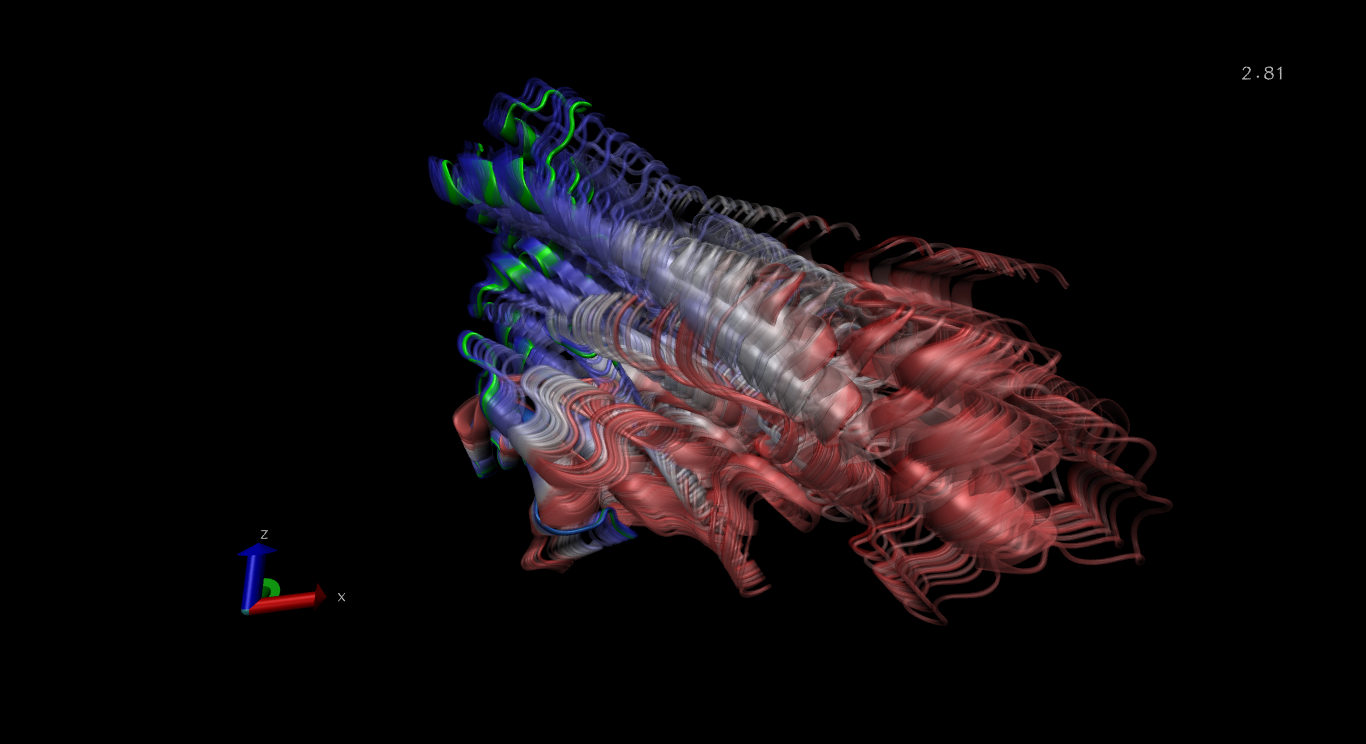

We want to check how the principal axis of the protein changes: (TODO)

In [48]:
CA = u.select_atoms("protein and name CA")

I = CA.moment_of_inertia()
UT = CA.principal_axes()
p1, p2, p3 = CA.principal_axes()
print(p1)
print(p2)
print(p3)

# transpose the row-vector layout UT = [p1, p2, p3]
U = UT.T
print(U)

# test that U diagonalizes I
Lambda = U.T.dot(I.dot(U))
# check that it is diagonal (to machine precision)
print(np.allclose(Lambda - np.diag(np.diagonal(Lambda)), 0))

[-0.58705346  0.29028025  0.7557153 ]
[0.52108434 0.84990337 0.0783287 ]
[ 0.6195477  -0.43977454  0.6501992 ]
[[-0.58705346  0.52108434  0.6195477 ]
 [ 0.29028025  0.84990337 -0.43977454]
 [ 0.7557153   0.0783287   0.6501992 ]]
True
